<a href="https://colab.research.google.com/github/ASBRUC/DSPS_ABruce/blob/main/ViTr/ViTforGW_tocomplete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from glob import glob
import pandas as pd
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import rescale
import numpy as np
from functools import reduce
import pylab as plt

DIRECTLYFROMGRAVITYSPY = False

In [2]:

def read_and_crop_image(filename, x, y):
    """Read in a crop part of image you want to keep

    Parameters
        filename (str):
            the file you would like to pixelize

        x (float, list):
            xrange of pixels to keep

        y (float, list):
            yrange of pixels to keep


    Returns
        image_data (`np.array):
            this images is taken from rgb to gray scale
            and then downsampled by the resolution.
    """
    xmin = x[0]
    xmax = x[1]
    ymin = y[0]
    ymax = y[1]
    image_data = io.imread(filename)
    image_data = image_data[xmin:xmax, ymin:ymax, :3]
    return image_data


def read_grayscale(filename, resolution=0.3, x=[66, 532], y=[105, 671],
                   verbose=False):
    """Convert image from RGB to Gray, downsample

    Parameters
        filename (str):
            the file you would like to pixelize

        resolution (float, optional):
            default: 0.3

        verbose (bool, optional):
            default: False

    Returns
        image_data (`np.array):
            this images is taken from rgb to gray scale
            and then downsampled by the resolution.
    """
    image_data = read_and_crop_image(filename, x=x, y=y)

    image_data = rgb2gray(image_data)
    image_data = rescale(image_data, resolution, mode='constant',
                         preserve_range='True', channel_axis=None)

    #dim = int(reduce(lambda x, y: x * y, image_data.shape))
    #image_data = np.reshape(image_data, (dim))
    image_data = np.array(image_data, dtype='f')

    return image_data


def read_rgb(filename, resolution=0.3, x=[66, 532], y=[105, 671],
             verbose=False):
    """Convert image from RGB to Gray, downsample

    Parameters
        filename (str):
            the file you would like to pixelize

        resolution (float, optional):
            default: 0.3

        verbose (bool, optional):
            default: False

    Returns
        image_data (`np.array):
            this images is taken from rgb to gray scale
            and then downsampled by the resolution.
    """
    image_data = read_and_crop_image(filename, x=x, y=y)
    image_data = rescale(image_data, resolution, mode='constant',
                         preserve_range='True', channel_axis=-1)
    dim = int(reduce(lambda x, y: x * y, image_data[:, :, 0].shape))
    image_data_r = np.reshape(image_data[:, :, 0], (dim))
    image_data_g = np.reshape(image_data[:, :, 1], (dim))
    image_data_b = np.reshape(image_data[:, :, 2], (dim))

    return image_data_r, image_data_g, image_data_b

run the cell below to select your classes and read in teh images directly from GravitySpy

In [3]:
if DIRECTLYFROMGRAVITYSPY:
  labels = []
  imgs = np.zeros((2264, 140, 170))
  j, k = 0, 0
  for i,f in enumerate(glob("H1L1/Chirp/*")):
      #print(f)
      if k == 264:
          break
      img = read_grayscale(f)
      if i%100 == 0 :
          plt.imshow(img)
          plt.title(f"Chirp {i} ")
          plt.show()
      imgs[j] = img
      labels.append(["chirp"])
      k += 1
      j += 1
  print(i)
  k = 0
  for i,f in enumerate(glob("H1L1/Low_Frequency_Burst/*")) :
      if k == 1000:
          break
      img = read_grayscale(f)
      if i%100 == 0 :
          plt.imshow(img)
          plt.title(f"Low_Frequency_Burst {i}")
          plt.show()

      imgs[j] = img
      labels.append(["low_frequency_burst"])
      k += 1
      j += 1
  print(i,j,k)

  k = 0
  for i,f in enumerate(glob("H1L1/Koi_Fish/*")) :
      if k == 1000:
          break
      img = read_grayscale(f)
      if i%100 == 0 :
          plt.imshow(img)
          plt.title(f"koi_fish {i}")
          plt.show()

      imgs[j] = img
      labels.append(["koi_fish"])
      k += 1
      j += 1


run the two cells below to read the pre-made array of data

In [4]:
if not DIRECTLYFROMGRAVITYSPY:
  labels = pd.read_csv("gw_labels.csv", index_col=0)
  labels

In [9]:
import tensorflow as tf
if not DIRECTLYFROMGRAVITYSPY:
  imgs = np.load(open("gw_imgs.npy", "rb"))
  imgs.shape
#reshaping images with a new axis because vision transformers are commonly built for 3 axis images
imgs = imgs[:,:,:,np.newaxis]
imgs.shape

(2264, 140, 170, 1)

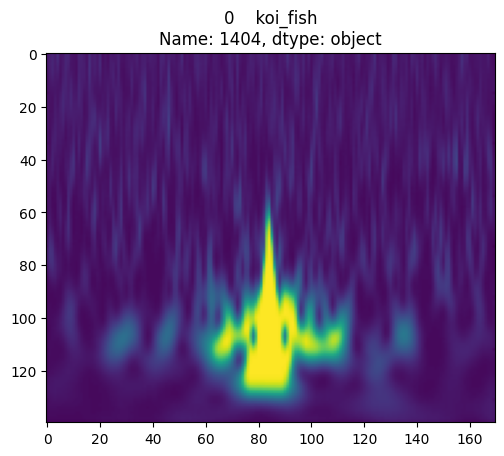

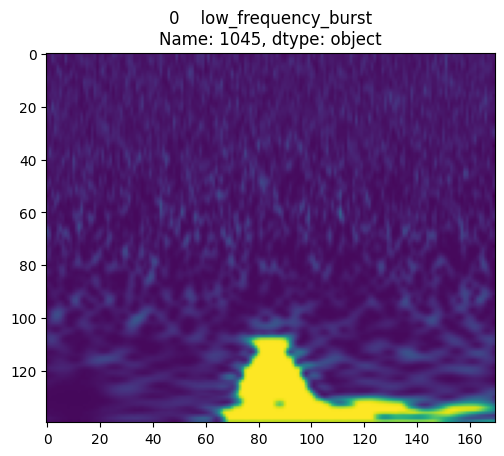

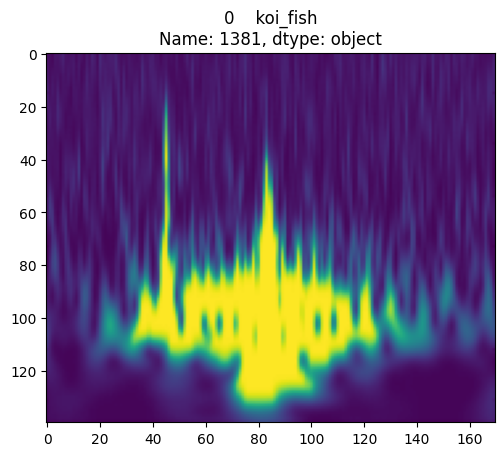

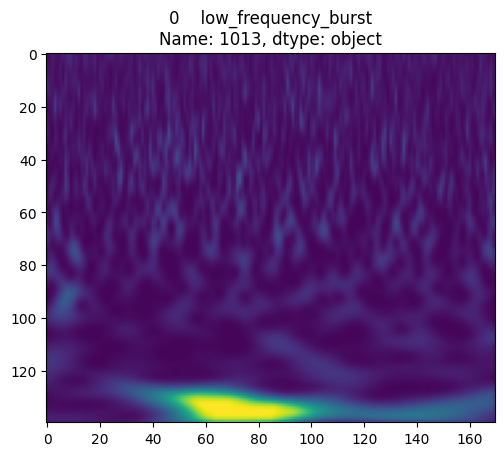

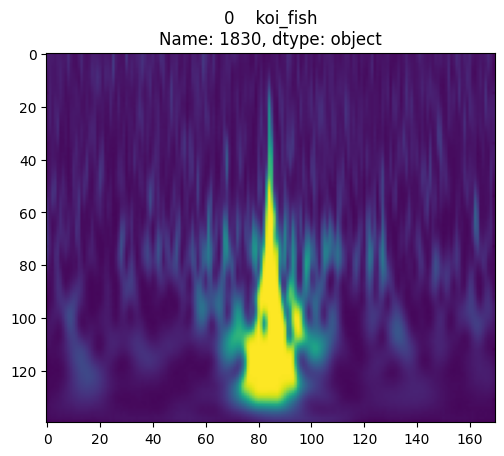

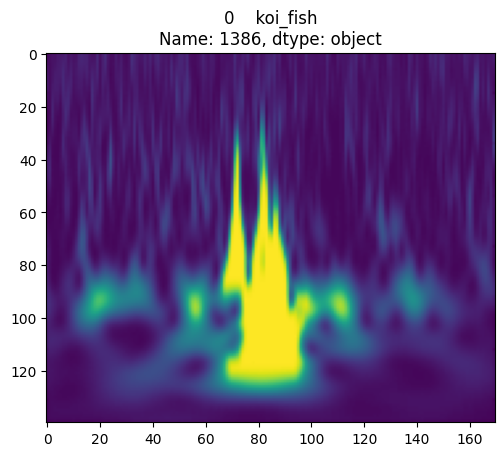

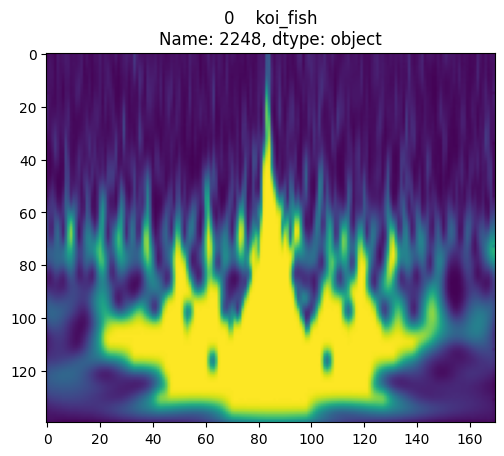

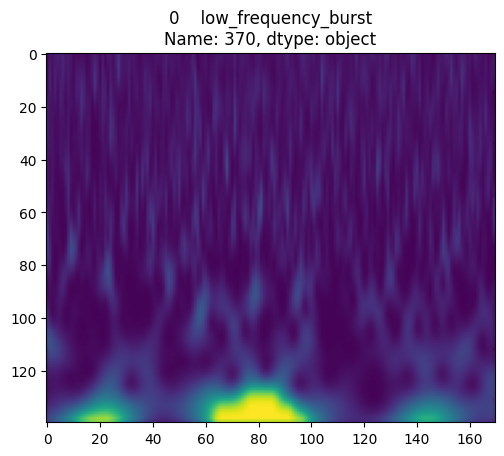

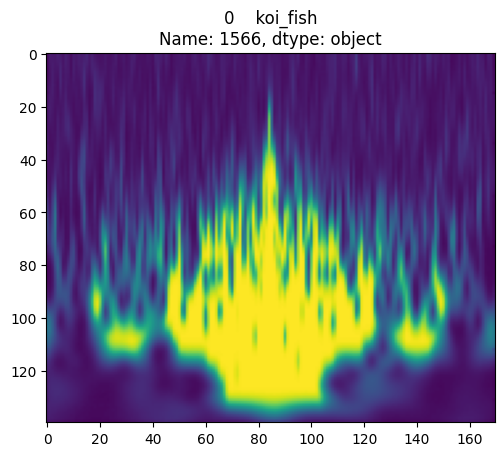

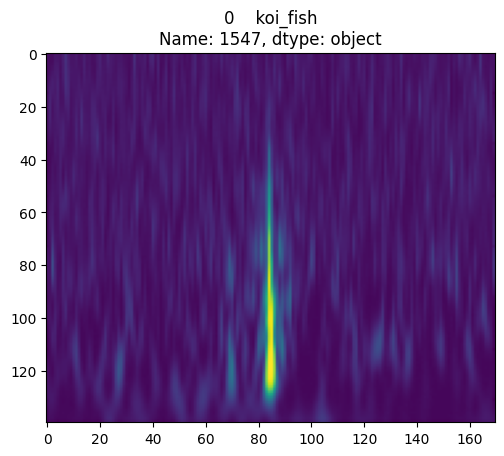

In [7]:
#show a few images
np.random.seed(303)
for i in np.random.choice(imgs.shape[0], 10):
  plt.imshow(imgs[i])
  plt.title(labels.iloc[i])
  plt.show()

array(['chirp', 'low_frequency_burst', 'koi_fish'], dtype=object)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Encode string labels into numerical format
label_encoder = LabelEncoder()
encoded_labels_sparse = label_encoder.fit_transform(labels)
#sparse encoder makes a 1D label with numbers 0-n, use sparse_categorical_crossentropy loss

# Convert to one-hot encoded format
num_classes = len(labels["0"].unique())
encoded_labels = tf.keras.utils.to_categorical(encoded_labels_sparse, num_classes=num_classes)
...
encoded_labels[:20], encoded_labels[-20:]
#use categorical_crossentropy loss

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]),
 array([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]]))

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Encode string labels into numerical format
label_encoder = LabelEncoder()
encoded_labels_sparse = label_encoder.fit_transform(labels)
#sparse encoder makes a 1D label with numbers 0-n, use sparse_categorical_crossentropy loss

# Convert to one-hot encoded format
num_classes = len(labels["0"].unique())
encoded_labels = tf.keras.utils.to_categorical(encoded_labels_sparse, num_classes=num_classes)
...
encoded_labels[:20], encoded_labels[-20:]
#use categorical_crossentropy loss
#IMPORTANT:
# stratify: Perform the train-test split with same fraction of labels in training and testing - for imbalanced datasets
# Shuffle the data because the labels are ordered!
X_train, X_test, y_train, y_test = train_test_split(imgs, encoded_labels,
                                                    test_size=0.1,
                                                    random_state = 303,
                                                    shuffle = True,
                                                    stratify = encoded_labels)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Show the mapping of original labels to encoded numbers
print("\nLabel encoding mapping:")
for i, label_name in enumerate(label_encoder.classes_):
    print(f"{label_name}: {i}")

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X_train shape: (2037, 140, 170, 1)
X_test shape: (227, 140, 170, 1)
y_train shape: (2037, 3)
y_test shape: (227, 3)

Label encoding mapping:
chirp: 0
koi_fish: 1
low_frequency_burst: 2


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

class PatchExtract(layers.Layer):
    """Extract patches from images."""
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class MinimalViT(keras.Model):
    """Minimal Vision Transformer for 140x170 images."""
    def __init__(self, image_size=(140, 170), patch_size=14, num_classes=3):
        super().__init__()
        # Adjust to be divisible by patch_size
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size[0] // patch_size) * (image_size[1] // patch_size)
        self.embed_dim = 64

        # Patch extraction and embedding
        self.patch_extract = PatchExtract(patch_size)
        self.patch_embed = layers.Dense(self.embed_dim)

        # CLS token and position embeddings
        self.cls_token = self.add_weight(
            shape=(1, 1, self.embed_dim),
            initializer='random_normal',
            trainable=True,
            name='cls_token'
        )
        self.pos_embed = self.add_weight(
            shape=(1, self.num_patches + 1, self.embed_dim),
            initializer='random_normal',
            trainable=True,
            name='pos_embed'
        )

        # Transformer encoder layers (corrected structure)




    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]

        # Extract patches
        patches = self.patch_extract(inputs)

        # Embed patches
        x = self.patch_embed(patches)

        # Add CLS token
        cls_tokens = tf.tile(self.cls_token, [batch_size, 1, 1])
        x = tf.concat([cls_tokens, x], axis=1)  # (batch, num_patches+1, embed_dim)

        # Add position embeddings
        x += self.pos_embed

        # Transformer encoder layers
        # Single transformer block logic
        # Layer Normalization 1

        x_norm1 = self.norm1(x)
        # Multi-Head Self-Attention
        attn_output = self.attn(query=x_norm1, key=x_norml, value=x_norm1, training = traiing)
        attn_output = self.dropout_attn(attn_output, training=training)
        x = x + attn_output

        # Layer Normalization 2 and MLP
        x_norm2 = self.norm2(x)
        mpl_output = self.mlp(x_norm2, training = training)

        # Use CLS token for classification


        return self.head(x)


In [18]:
import tensorflow as tf
import numpy as np
num_classes = 3
# Assuming your data is already loaded
# X_train shape: (n_samples, 140, 170, 3) - now correct with 3 channels
# y_train shape: (n_samples, 3) - one-hot encoded

# 1. Create minimal ViT model
# IMPORTANT: Set num_classes to 3, matching your dataset's actual number of classes
model = MinimalViT(patch_size=14, num_classes=num_classes)

# 2. Build with input shape
# Input shape should now be (None, 140, 170, 3) as imgs_processed will have 3 channels
model.build(input_shape=(None, 140, 170, 1))

# 3. Compile
# IMPORTANT: Change loss to 'categorical_crossentropy' because y_train is one-hot encoded
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# 4. Train
history = model.fit(X_train, y_train, epochs = 10, validation_split = 0.2, batch_size =32)

# 5. Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.2%}")

# 6. Predict
predictions = model.predict(X_test)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'minimal_vi_t_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/10


AttributeError: Exception encountered when calling MinimalViT.call().

[1m'MinimalViT' object has no attribute 'norm1'[0m

Arguments received by MinimalViT.call():
  • inputs=tf.Tensor(shape=(None, 140, 170, 1), dtype=float32)
  • training=True

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [ ]:
# Convert model predictions from probabilities to class labels
y_pred_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded y_test back to original class labels for comparison
y_true_classes = np.argmax(y_test, axis=1)

# Get class names from the label encoder for better readability in the matrix
class_names = label_encoder.classes_

print("Predicted classes sample:", y_pred_classes[:10])
print("True classes sample:", y_true_classes[:10])


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
